In [122]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/flower1022/setid.mat
/kaggle/input/flower1022/102flowers.tgz
/kaggle/input/flower1022/imagelabels.mat


In [123]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt


In [124]:
labels = scipy.io.loadmat(labels_path)['labels'][0]
setid = scipy.io.loadmat(setid_path)

train_ids = setid['trnid'][0] - 1
val_ids   = setid['valid'][0] - 1
test_ids  = setid['tstid'][0] - 1

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Train: 1020, Val: 1020, Test: 6149


In [125]:
def make_dataframe(indices):
    filepaths = [f'image_{i+1:05d}.jpg' for i in indices]
    labels_subset = labels[indices] - 1
    df = pd.DataFrame({'filename': filepaths, 'class': labels_subset})
    df['class'] = df['class'].astype(str) 
    return df

train_df = make_dataframe(train_ids)
val_df   = make_dataframe(val_ids)
test_df  = make_dataframe(test_ids)

In [126]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=images_dir,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=images_dir,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory=images_dir,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1020 validated image filenames belonging to 102 classes.
Found 1020 validated image filenames belonging to 102 classes.
Found 6149 validated image filenames belonging to 102 classes.


In [127]:
from tensorflow.keras.applications import ResNet50

weights_path = "/kaggle/input/resnet50-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

base_model = ResNet50(weights=weights_path,include_top=False,input_shape=(224, 224, 3))

base_model.trainable = False


In [128]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_22[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [129]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    return data_augmentation

In [130]:
data_augmentation = data_augmenter()

In [131]:
def resnetflower102model(image_shape=IMG_SIZE,data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
   
    base_model = ResNet50(weights=weights_path,include_top=False,input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model(x,training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(102, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model
    

In [132]:
model = resnetflower102model()

In [133]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [134]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 224, 224,  │          0 │ input_layer_23[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 224, 224)  │          0 │ sequential_19[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 224, 224)  │          0 │ sequential_19[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 224, 224)  │          0 │ sequential_19[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 224, 224,  │          0 │ get_item_18[0][0… │
│                     │ 3)                │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 224, 224,  │          0 │ stack_6[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_6[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 102)       │    208,998 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [135]:
initial_epochs = 10
history = model.fit(train_generator,validation_data=val_generator,epochs=initial_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 575ms/step - accuracy: 0.0242 - loss: 5.4881 - val_accuracy: 0.2598 - val_loss: 3.2224
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - accuracy: 0.2302 - loss: 3.1901 - val_accuracy: 0.5167 - val_loss: 2.1115
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4732 - loss: 2.1722 - val_accuracy: 0.6265 - val_loss: 1.5519
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.6244 - loss: 1.5478 - val_accuracy: 0.6941 - val_loss: 1.2837
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.7235 - loss: 1.2182 - val_accuracy: 0.7029 - val_loss: 1.1906
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 446ms/step - accuracy: 0.7650 - loss: 1.0598 - val_accuracy: 0.7422 - val_loss: 1.0496
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 447ms/step - accuracy: 0.8077 - loss: 0.8279 - val_accuracy: 0.7471 - val_loss: 1.0019
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.8409 - loss: 0.6925 - val_accu

In [136]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

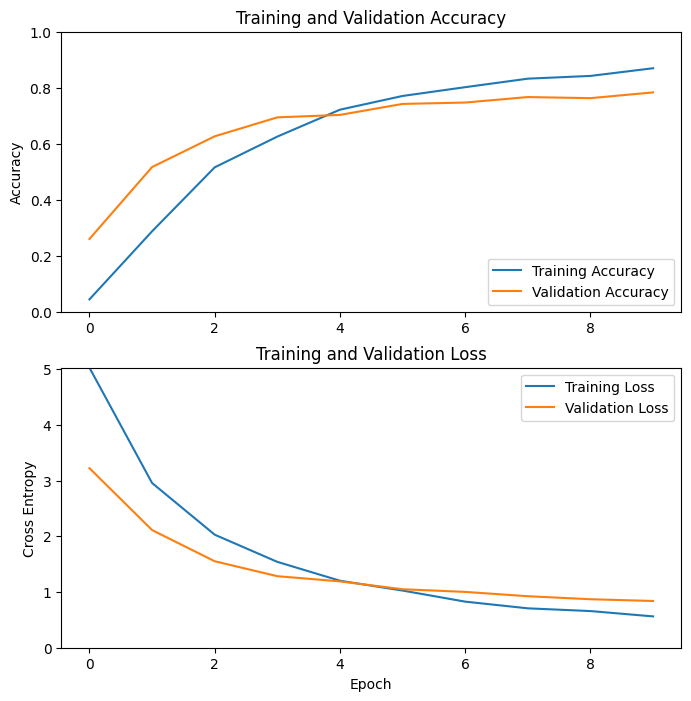

In [137]:
plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()
